In [1]:
from natsort import natsorted
import matplotlib.pyplot as plt
from glob import glob
import json
from functools import partial
import numpy as np
from cachier import cachier
from tqdm import tqdm
import imageio
from skimage import img_as_float32
import cv2 as cv2
from math import pi, e, sqrt, cos, sin
from scipy.stats import norm, multivariate_normal
from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
ztqdm = partial(tqdm, position=0, leave=True)
cachier = partial(cachier, pickle_reload=False, cache_dir='data/cache')

In [3]:
SIZE = (768, 1024)
NEW_SIZE = SIZE[::-1]
DATA_PATH_PAIRS = list(zip(
    natsorted(glob(f'../data/images-{SIZE[1]}x{SIZE[0]}/*.png')),
    natsorted(glob(f'../data/masks-{SIZE[1]}x{SIZE[0]}/*.png')),
))
DATA_IMGS = np.array(
    [cv2.resize(img_as_float32(imageio.imread(img_path)), NEW_SIZE)
     for img_path, _ in tqdm(DATA_PATH_PAIRS, 'Loading Images')])
DATA_MSKS = np.array(
    [cv2.resize(img_as_float32(imageio.imread(msk_path)), NEW_SIZE,  interpolation = cv2.INTER_NEAREST)
     for _, msk_path in tqdm(DATA_PATH_PAIRS, 'Loading Masks')])


Loading Masks: 100%|██████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 148.59it/s]


In [4]:
def normalise_data(data):
    return np.subtract(data, np.min(data)) / np.subtract(np.max(data), np.min(data))

def show_image(image,cs=False,cmap= None, title=None):
    if cs:
        norm_img = normalise_data(image)
    else:
        norm_img = image
    plt.title(title)
    plt.imshow(norm_img, cmap= cmap)
    plt.xticks([])
    plt.yticks([])

In [5]:
class ImageDataUtils(object):
    
    def train_test_split(self, images, masks, train_size=0.7, validation_size=0.15, test_size=0.15, seed=5):
        """
        Split a set of images and masks according to a random specified set sizes.

        """
        # Get indices
        np.random.seed(seed)
        all_indices = np.arange(len(images))
        np.random.shuffle(all_indices)
        train_indices = all_indices[0: int(len(images)* train_size) + 1]
        validate_inidices = all_indices[len(train_indices): len(train_indices) + int(len(images)* validation_size)]
        test_indices = all_indices[len(train_indices)+len(validate_inidices): len(train_indices)+
                                   len(validate_inidices) + int(len(images)* test_size)]
        # Train data
        train_images = np.array([images[i] for i in train_indices])
        train_masks = np.array([masks[i] for i in train_indices])
        # Validate data
        validate_images = np.array([images[i] for i in validate_inidices])
        validate_masks = np.array([masks[i] for i in validate_inidices])
        # Test data
        test_images = np.array([images[i] for i in test_indices])
        test_masks = np.array([masks[i] for i in test_indices])
        return train_images, train_masks, validate_images, validate_masks, test_images, test_masks


    def _get_kernel(self, g, sigma, size, k=None):   
        """
        Function to map kernel function to numpy matrix, 
        Note result is normalized.
        
        """
        # Center x and y coordinates and return a numpy matrix from g function
        kernel =  np.fromfunction(lambda x, y: 
                                 g((x - (size - 1) / 2), (y - (size - 1) / 2), sigma, k),
                                 (size, size))  
        return kernel.astype(np.float32)

    def _dog(self, sigma, size, k):
        """
        Get a Difference of Gaussian filter
    
        """
        def _g(x, y, sigma, k):
            return (2*pi*sigma**2) * \
                    e**(-1 * ((x**2 + y**2) / (2 * sigma**2))) - \
                    (1 / 2 * pi * k**2 * sigma**2) *\
                    e**(-1 * ((x**2 + y**2)/(2 * k**2 * sigma**2)))
                
        if k <= 1.0:
            raise ValueError("k must be > 1.0")
        
        return self._get_kernel(_g, sigma, size, k)
    
    """
    Get a Laplacian of Gaussian kernel
    
    """
    def _log(self, sigma, size):  
        
        def _g(x, y, sigma, k= None):
            return (1/(pi * sigma**4)) * \
                    (1 - ((x**2 + y**2)/(2 * sigma**2))) * \
                    e ** (-1 * ((x**2 + y**2)/(2 * sigma**2)))
                
        return self._get_kernel(_g, sigma, size)
    
    def extract_features(self, image, gaus=(3,3), dog_sigma=30, dog_size=65, dog_k=6):
        """
        Parameters
        ----------
        image : numpy array of shape (n_sample, col, row, n_channels)
        gaus : tuple of gaussian kernel for blurring input image
        dog_sigma : int, sigma value for DoG features
        dog_size  : int, size of DoG kernel
        dog_k : int, k parameter for DoG 
        show_feature_plots : bool, verbose option to plot features
        
        Returns
        ---------- 
        numpy array : 9 x flattened image shape (786432) features of image.
        1 - 3: R, G, B channels
        4 - 6: DoG of RGB channels
        7 - 9: H, S, V channels
    
        """
         # Gaussian blur image as a first step to reduce noise
        image_ = cv2.GaussianBlur(image, gaus, 0).astype(np.float32)  
        # RBG Features
        features = None
        for rgb_channel in cv2.split(image_):
            if features is None:
                features = np.array(normalise_data(rgb_channel.flatten().astype(np.float32)))
            else:
                features = np.vstack((features, normalise_data(rgb_channel.flatten().astype(np.float32))))
                
        dog_kernel = self._dog(dog_sigma, dog_size, dog_k)
        convolved = cv2.filter2D(image_, -1, dog_kernel)    
        for convolved_rgb_channel in cv2.split(convolved):
            if features is None:
                features = np.array(normalise_data(convolved_rgb_channel.flatten().astype(np.float32))) 
            else:
                features = np.vstack((features, normalise_data(convolved_rgb_channel.flatten().astype(np.float32))))
            
        return features
    
    def apply_mask(self, features, mask, invert_mask=False):
        """Apply the mask to a data set"""
        data = []
        mask_ = mask.astype(np.bool).flatten()
        if invert_mask:
            mask_ = np.invert(mask_)
        for feature in features:
            masked_feature = feature[mask_ == True]
            data.append(masked_feature.flatten())
        return np.array(data)

# Train, validation and training split
Split data randomly into sets of 70% training, 15% validation and 15% testing

In [6]:
data_utils = ImageDataUtils()

train_images, train_masks, \
validate_images, validate_masks, \
test_images, test_masks = data_utils.train_test_split(DATA_IMGS, DATA_MSKS, 
                                                      train_size=0.7, 
                                                      validation_size=0.15, 
                                                      test_size=0.15)

# Pre-process data, and extract the features:
Flattened and normalised feature vectors for each image of
- RGB channels
- DoG on RGB channels

The training data is split into two sets (foreground and background) to train two GMM models. Lastly all of the training
data are concatenated into a signle dimension so that we have data sets in the format (n_features, samples)

In [7]:
train_data = np.array([data_utils.extract_features(train_image) for train_image in train_images])
validate_data = np.array([data_utils.extract_features(validate_image) for validate_image in validate_images])
test_data = np.array([data_utils.extract_features(test_image) for test_image in test_images])

Use masks to split training data to foreground and background data sets

In [8]:
train_bg_data = [data_utils.apply_mask(features, mask, invert_mask=True) 
                for features, mask in zip(train_data, train_masks)]
train_fg_data = [data_utils.apply_mask(features, mask, invert_mask=False) 
                for features, mask in zip(train_data, train_masks)]

In [9]:
train_bg_data = np.concatenate(train_bg_data, axis=1)
train_fg_data = np.concatenate(train_fg_data, axis=1)

## Gaussian Mixture Model (GMM)

Since our data is composed of intensities that might be modelled using gaussian distributions, we investigate the use of a Mixture Gausssian Model (GMM), which is an unsupervised learning approach that aims to fit a mixture of gasussian distributions to model the data with $d$ dimensions of features. And we want to use the GMM to fit clusters or mixture of gaussians to our data set, but we do not know where they are, or how they are shaped.
It differs from normal KNN, since the clusters are gaussian distributions, which are parameterised by a mean and covariance. Which allows us to model the probability that our data belongs to either clusters in elliptical shapes, as opposed to the circular shapes clustered by KNN.

![GMM](resources/GMM_illistration.png)

### Expectation Maximisation (EM)
We find the gaussian mixture model by using the EM algorithm to find k to minimize $\frac{(x-u_k)^2}{\sigma^2}$.
EM introduces a latent variable $h$ for each cluster $K$, and the GMM is a marginalisation of the joint probability distribution $P(\vec{x}, h)$, where $\vec{x}$ represents our feature vectors.  We define a variable $h \in \{1 \dots K\}$ and then the probability distribution for each categorical variable is written as <br>
$Pr(\times|h, \theta) = Norm_x[\mu_h, \Sigma_h]$ <br>
$Pr(h|\theta) = Cat_h[\lambda]$ <br>

Then we can recover the density by marginalising out the $h$ from the joint probability distribution $Pr(\vec{x},h)$ <br>
$
\begin{align}
Pr(\vec{x}|\theta) & = \sum^K_{k=1} Pr(\vec{x}, h = k | \theta)\\
                   & = \sum^K_{k=1} Pr(\vec{x}, h = k, \theta) Pr(h=k|\theta)\\
                   & = \sum^K_{k=1} \lambda_k Norm_\vec{x}[\mu_k, \Sigma_h]   \\
\end{align}
$

![GMM](resources/GMM_marginilisation.png)

This formulation allows us to fit the model with the Expectation Maximisation algorithm using closed-form solutions in an iterative process. The goal is to learn the model parameters $\theta = \{\lambda_{1 \dots K}, \mu_{1 \dots K}, \Sigma_{1 \dots K} \}$ from our training features $\vec{x}$. The two steps of the EM algorithm include

#### 1. E-Step (Expectation)
The probability of $h$ is computed using the current estimates of the parameters $\theta$. So for each point we estimate the probability that each Gaussian generated it $Pr(h_i = k | \vec{x}_i, \theta^{[t]})$, which might also be described as the responsibility of the $k^{th}$ Gaussian for the $i^{th}$ data point expressed by <br>
$r_{ik} = \frac{\lambda_k Norm_{x_i} [\mu_k, \Sigma_k]}{\sum^K_{j=1}\lambda_j Norm_\vec{x_i} [\mu_j, \Sigma_j]}$

![GMM](resources/GMM_Estep.png)


#### 1. M-Step (Maximisation)
Using the computed resposibilities the maximisation step then updates the model parameters $\theta$. And in our case we use maximum likelihood estimation that allows the following closed form update rules <br>


$\lambda_k^{[t + 1]} = \frac{\sum^I_{i=1} r_{ik}} {\sum^K_{j=1}\sum^I_{i=1} r_{ij}  }   $

$\mu_k^{[t + 1]} = \frac{\sum^I_{i=1} r_{ik} \vec{x_i}} {\sum^I_{i=1} r_{ik}} $

$\Sigma_k^{[t + 1]} = \frac{\sum^I_{i=1} r_{ik} (\vec{x_i} - \mu_k^{[t + 1]}) (\vec{x_i} - \mu_k^{[t + 1]})^T}{\sum^I_{i=1} r_{ik}}$

![GMM](resources/GMM_Mstep.png)

#### The EM-flow
![EM](resources/EM_flow.png)
- The $k$ clusters center are randomly initialised 
- The responsibilities are recomputed during the E-Step, and the model parameters are updated during the M-Step.
- The iterative process is repeated until convergence (Parameter change is smaller then some threshold.)


### GMM using EM

In [10]:
class GuassianParameters(object):
    """Distribution parameters"""

    def __init__(self, lmbda, mu, cov):
        self.lmbda = lmbda
        self.mu = mu
        self.cov = cov

    def difference_between(self, other):
        return abs(self.lmbda - other.lmbda) + \
               euclidean(self.mu, other.mu) + \
               euclidean(self.cov.flatten(), other.cov.flatten())


class GaussianMixtureModel(object):
    """Multivariate Gaussian Mixture Model"""

    def _get_init_params(self, X):
        n_features = X.shape[1]
        # Initial weigths evenly distributed
        lmbda = 1 / self.k_size
        # Initial means, random observations from input data
        mu = np.random.choice(X.flatten(), n_features)
        # Iniital covariance
        cov = np.random.random((n_features, n_features))
        cov *= cov.T
        cov += n_features * np.eye(n_features)
        return GuassianParameters(lmbda, mu, cov)

    def __init__(self, k_size=5, tol=1e-3, min_iter=5, max_iter=60, verbose=True):
        self.fitted = False
        self.k_size = k_size
        self.tol = tol
        self.min_iter = min_iter
        self.max_iter = max_iter
        self.verbose = verbose
        self.fitted_parameters = None

    def _estep(self, X, gaussian_parameters):
        """Calculate the responsibility for each cluster for all of the data points,"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.k_size))
        weighted_gaussians = np.zeros((n_samples, self.k_size))
        # Get normal distributions using current parameter set
        for k in range(self.k_size):
            weighted_gaussians[:, k] = gaussian_parameters[k].lmbda * \
                                       multivariate_normal.pdf(X, gaussian_parameters[k].mu, gaussian_parameters[k].cov)
        # Compute responsibility for each cluster
        for k in range(self.k_size):
            responsibilities[:, k] = weighted_gaussians[:, k] / np.sum(weighted_gaussians, axis=1, initial=1e-10)
        return responsibilities

    def _mstep(self, X, responsibilities):
        """Compute model parameters using maximum likelikhood closed form solutions"""
        gaussian_parameters = []
        for k in range(self.k_size):
            k_sum_responsibility = np.sum(responsibilities[:, k])
            lmbda = k_sum_responsibility / (np.sum(np.sum(responsibilities, axis=1)))
            mu = np.dot(responsibilities[:, k], X) / k_sum_responsibility
            standardised_x = X - mu
            cov = np.dot((standardised_x.T * responsibilities[:, k]), standardised_x) / k_sum_responsibility
            # Add small value to diagonal to prevent singular matrix
            cov += np.eye(len(cov)) * 1e-10
            gaussian_parameters.append(GuassianParameters(lmbda, mu, cov))
        return gaussian_parameters
    
    def save_parameters(self, filename):
        """Save the model parameters to file"""
        assert self.fitted, "Model is not yet fitted."
        np.save(filename, self.fitted_parameters)
    
    def load_parameters(self, filename):
        """Load the model parameters from file"""
        self.fitted_parameters = np.load(filename +'.npy',allow_pickle=True)
        self.fitted = True
        
    def plot_gaussian(self, X, feature_1_index, feature_2_index, component_number):
        """Plots a gaussian distribution for two random variables"""
        assert self.fitted, "Model is not yet fitted."
        n_samples = X.shape[0]
        gaussian_pdfs = np.zeros((n_samples, self.k_size))
        for k in range(self.k_size):
            gaussian_pdfs[:, k] = self.fitted_parameters[k].lmbda *\
            multivariate_normal.pdf(X, self.fitted_parameters[k].mu, self.fitted_parameters[k].cov)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.plot_surface(X[:, feature_1_index], 
                        X[:, feature_2_index], 
                        gaussian_pdfs[:, component_number] ,cmap='viridis',linewidth=0)
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Likelihood')
        plt.show()
        
    def fit(self, X):
        """Fit the model according to the given training data.

        Parameters
        ----------
        X : numpy array, of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples/pixels and
            n_features is the number of features.

        """
        converged = False
        run_iteration = 1
        # Initialise parameters
        gaussian_parameters = [self._get_init_params(X) for _k in range(self.k_size)]
        while not converged and run_iteration <= self.max_iter:
            # E-step
            responsibilities = self._estep(X, gaussian_parameters)
            # M-step
            new_gaussian_parameters = self._mstep(X, responsibilities)
            # Iterate until parameters experience change smaller than tolerance
            total_change = 0
            for k, parameters in enumerate(new_gaussian_parameters):
                total_change += parameters.difference_between(gaussian_parameters[k])
            if total_change < self.tol and run_iteration > self.min_iter:
                converged = True
            gaussian_parameters = new_gaussian_parameters
            if self.verbose:
                print("Iteration #{0}, change in parameters {1}".format(run_iteration, total_change))
            run_iteration += 1
            
        self.fitted_parameters = gaussian_parameters
        self.fitted = True
        
        if self.verbose:
            print("Finished in {0} iterations".format(run_iteration - 1))
            
    def predict(self, X):
        """ Predict's the probability density the input observations by marginalising
        out the joint probability distributions.
        
        Parameters
        ----------
        X : numpy array, of shape (n_samples, n_features)
            Testing vector, where n_samples is the number of samples/pixels and
            n_features is the number of features.
        
        Returns
        ----------
        y : numpy array, of shape (n_samples)
            Estimated probability density from the mixture of gaussian models.
        """
        assert self.fitted, "Model is not yet fitted."
        n_samples = X.shape[0]
        gaussian_pdfs = np.zeros((n_samples, self.k_size))
        for k in range(self.k_size):
            gaussian_pdfs[:, k] = self.fitted_parameters[k].lmbda *\
            multivariate_normal.pdf(X, self.fitted_parameters[k].mu, self.fitted_parameters[k].cov)
        # Return marginalised distribution
        return np.sum(gaussian_pdfs, axis=1)

**Background model**

In [11]:
bg_gmm = GaussianMixtureModel()
bg_gmm.fit(train_bg_data.T)

Iteration #1, change in parameters 79.43740975072042
Iteration #2, change in parameters 0.012996177606300752
Iteration #3, change in parameters 0.05620474937803228
Iteration #4, change in parameters 0.15217696315190313
Iteration #5, change in parameters 0.16459611788670195
Iteration #6, change in parameters 0.1801253563594018
Iteration #7, change in parameters 0.17338621119328285
Iteration #8, change in parameters 0.16127863504672205
Iteration #9, change in parameters 0.18812908819012855
Iteration #10, change in parameters 0.1918986604731479
Iteration #11, change in parameters 0.16152831159366782
Iteration #12, change in parameters 0.14854045908629326
Iteration #13, change in parameters 0.12878702603274825
Iteration #14, change in parameters 0.10796152600020921
Iteration #15, change in parameters 0.08238704157607385
Iteration #16, change in parameters 0.0595499222562206
Iteration #17, change in parameters 0.050130647123780125
Iteration #18, change in parameters 0.04436345150232728
Iter

**Foreground model**

In [12]:
fg_gmm = GaussianMixtureModel()
fg_gmm.fit(train_fg_data.T)

Iteration #1, change in parameters 80.03211249178665
Iteration #2, change in parameters 0.03378099767418124
Iteration #3, change in parameters 0.07936074909766108
Iteration #4, change in parameters 0.21321926222194243
Iteration #5, change in parameters 0.3985531762798284
Iteration #6, change in parameters 0.47948086524062483
Iteration #7, change in parameters 0.3783289749983527
Iteration #8, change in parameters 0.2794349137987201
Iteration #9, change in parameters 0.2810133008285232
Iteration #10, change in parameters 0.3432099936386448
Iteration #11, change in parameters 0.3853426560621266
Iteration #12, change in parameters 0.3160843215610648
Iteration #13, change in parameters 0.17995805608688792
Iteration #14, change in parameters 0.14105029356580798
Iteration #15, change in parameters 0.12481403692095244
Iteration #16, change in parameters 0.11260745375752639
Iteration #17, change in parameters 0.10308677849261977
Iteration #18, change in parameters 0.09628679182602906
Iteration 

**Posterior probabilities** <br>

$P(class=fg\  | \ \vec{x}) =  \frac{\lambda Norm_\vec{x} [\vec{\mu}_{fg} , \Sigma_{fg}]}
                                   {\lambda Norm_\vec{x} [\vec{\mu}_{fg} , \Sigma_{fg}] \ + \ (1 - \lambda)
                                   Norm_\vec{x} [\vec{\mu}_{bg} , \Sigma_{bg}]   }        $

In [18]:
def post_processing(fg_bg_pred, kernel_dims=5):
    """Apply morhpolical transformations of closing
    and opening"""
    kernel = np.ones((kernel_dims, kernel_dims),np.uint8)
    fg_bg_pred = cv2.morphologyEx(fg_bg_pred, cv2.MORPH_OPEN, kernel)
    fg_bg_pred = cv2.morphologyEx(fg_bg_pred, cv2.MORPH_CLOSE, kernel)
    return fg_bg_pred

def predict_foreground(X, bg_gmm, fg_gmm, lmbda):
    """Use Bayes' rule to predict the posterior probability of
    of pixels belonging to the foreground."""
    fg_dist = fg_gmm.predict(X)
    bg_dist = bg_gmm.predict(X)
    y = (lmbda * fg_dist) / ((lmbda * fg_dist) + ((1 - lmbda) * bg_dist))
    return post_processing((y >= 0.5).astype(np.float32))

def validate_predictions(validation_data, validation_masks, bg_gmm, fg_gmm, lmbda, plot=True):
    """Predictions on validation set, and average results"""
    predict_count = 0
    total_score = 0
    for data, mask in zip(validation_data, validation_masks):
        predict_count += 1
        y = predict_foreground(data.T, bg_gmm, fg_gmm, lmbda=lmbda)
        score = accuracy_score(y + 1, mask.flatten().round() + 1)
        print("Prediction #{0}, accuracy:{1}%".format(predict_count, round(score *100, 2)) )
        total_score += score
        if plot:
            show_image(y.reshape(NEW_SIZE[::-1]), cmap='gray')
            plt.show()
    print("Average accuracy:{0}%".format(round(total_score/predict_count *100, 2)) )

Prediction #1, accuracy:97.36%


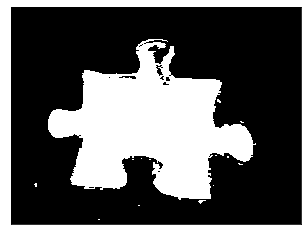

Prediction #2, accuracy:96.47%


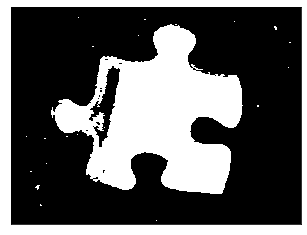

Prediction #3, accuracy:99.02%


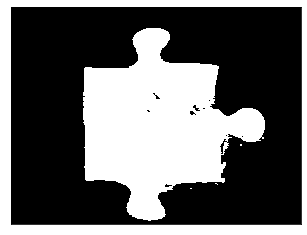

Prediction #4, accuracy:88.12%


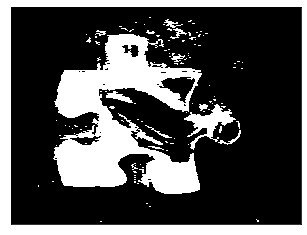

Prediction #5, accuracy:99.46%


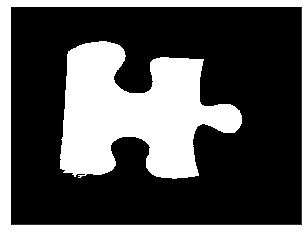

Prediction #6, accuracy:99.06%


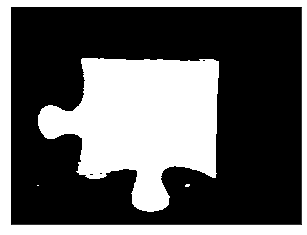

Prediction #7, accuracy:98.23%


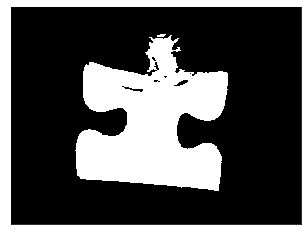

Average accuracy:96.82%


In [14]:
validate_predictions(validate_data, validate_masks, bg_gmm, fg_gmm, lmbda=0.4)

## 6-Fold Cross-Validation
Since the data set is limited, cross-validation might be used to evaluate the skill of the GMM for the unseen test data. A 6-Fold method is used, which splits the data into 6 groups of 8 puzzle pieces each. The method is popular since it results in a less biased estimate of the model's skill than other methods. The procedure used follows:
- Shuffle the test set data randomly
- Split the data set randomly into the 6 groups (with 8 image data each.)
- Then for each of these groups
 - Assign the group as a test set
 - Use all the remaining groups as the training set
 - Fit the model on the training set and evaluate it using the test set
 - Compute the score and discard the model
- Model performance is then the mean value of all scores
 

In [15]:
def validate_predictions_cv(validation_data, validation_masks, bg_gmm, fg_gmm, lmbda, plot=True):
    predict_count = 0
    total_score = 0
    for data, mask in zip(validation_data, validation_masks):
        predict_count += 1
        y = predict_foreground(data.T, bg_gmm, fg_gmm, lmbda=lmbda)
        score = accuracy_score(y + 1, mask.flatten().round() + 1)
        print("Prediction #{0}, accuracy:{1}%".format(predict_count, round(score *100, 2)) )
        total_score += score
        if plot:
            show_image(y.reshape(NEW_SIZE[::-1]), cmap='gray')
            plt.show()
    print("Average accuracy:{0}%".format(round(total_score/predict_count *100, 2)) )
    
    return  round(total_score/predict_count *100, 2)

In [16]:
def cross_val_manager(folds = 6, k_foreground=3, k_background=3, lmbda=0.1):
    #initialize accuracy list
    acc = []
    
    # copy the data
    data_imgs = DATA_IMGS.copy()
    data_msks = DATA_MSKS.copy()
    
    #create groups
    #create a random array containing the index of each img number in the data set
    #each row of this array will be a group
    img_indices = np.random.choice(np.arange(0, data_imgs.shape[0]), replace=False, 
                                   size=(folds, int(data_imgs.shape[0]/folds)))
    
    
    #main loop that selects one group of images as the test set and the remainder as the training sets
    for i in tqdm(range(img_indices.shape[0])):
        print('Fold: {}'.format(i))
        training_indices = []
        testing_indices = img_indices[i]
        for row in range(img_indices.shape[0]):

            if row != i:
                #print('row: {}'.format(row))
                training_indices.append(list(img_indices[row]))
        training_indices = np.asarray(training_indices)
        #print('\ntest: {}'. format(testing_indices))
        #print('\ntrain: {}'.format(training_indices))

        #flatten the array
        train_indices = training_indices.flatten()
        
        #get training imgs and masks
        train_imgs = np.array([data_imgs[i] for i in train_indices])
        train_msks = np.array([data_msks[j] for j in train_indices])
        
        #extract features for training data
        x_train = np.array([data_utils.extract_features(img) for img in train_imgs])

        #extract bg and fg pixels
        x_train_bg = [data_utils.apply_mask(features, mask, invert_mask=True) 
                      for features, mask in zip(x_train, train_msks)]
        x_train_fg = [data_utils.apply_mask(features, mask, invert_mask=False) 
                      for features, mask in zip(x_train, train_masks)]
        x_train_bg = np.concatenate(x_train_bg, axis=1)
        x_train_fg = np.concatenate(x_train_fg, axis=1)

        #train bg_gmm
        print('\nTraining bg_gmm:')
        print('')
        bg_gmm_cv = GaussianMixtureModel(k_size=k_background)
        bg_gmm_cv.fit(x_train_bg.T)

        #train fg_gmm
        print('\nTraining fg_gmm:')
        print('')
        fg_gmm_cv = GaussianMixtureModel(k_size=k_foreground, tol= 1e-2)
        fg_gmm_cv.fit(x_train_fg.T)
        
        #get test imgs and masks
        test_imgs = np.array([data_imgs[i] for i in testing_indices])
        test_msks = np.array([data_msks[j] for j in testing_indices])
        
        #extract features for test set
        x_test = np.array([data_utils.extract_features(test_img) for test_img in test_imgs])
        
        #get accuracy score for test set
        test_acc = validate_predictions_cv(x_test, test_msks, bg_gmm_cv, fg_gmm_cv, lmbda = lmbda, plot=True)
        
        #append accuracy to acc list
        acc.append(test_acc)
        
    print('\nThe accuracy scores achieved for each fold:')
    print(acc)
    
    final_acc = sum(acc)/len(acc)
    print('\nThe final accuracy of the system: {}'.format(final_acc))

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Fold: 0

Training bg_gmm:

Iteration #1, change in parameters 48.751519321813724
Iteration #2, change in parameters 0.01402147227167682
Iteration #3, change in parameters 0.05215188919494142
Iteration #4, change in parameters 0.1228613892048595
Iteration #5, change in parameters 0.1568809627936656
Iteration #6, change in parameters 0.14844645003022539
Iteration #7, change in parameters 0.11399635775410473
Iteration #8, change in parameters 0.09920899295820201
Iteration #9, change in parameters 0.09452740909563562
Iteration #10, change in parameters 0.07699883524442769
Iteration #11, change in parameters 0.07256813755748878
Iteration #12, change in parameters 0.06327181869610372
Iteration #13, change in parameters 0.04657673980937067
Iteration #14, change in parameters 0.0329475127288224
Iteration #15, change in parameters 0.02524706175506544
Iteration #16, change in parameters 0.021466141978465733
Iteration #17, change in parameters 0.020223015819489397
Iteration #18, change in paramet

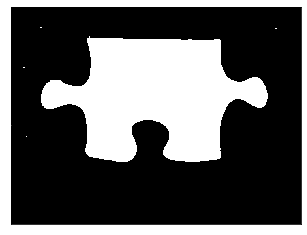

Prediction #2, accuracy:94.59%


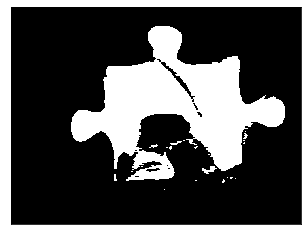

Prediction #3, accuracy:90.89%


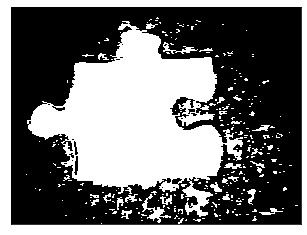

Prediction #4, accuracy:97.66%


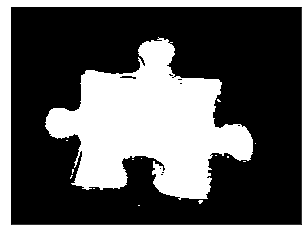

Prediction #5, accuracy:96.88%


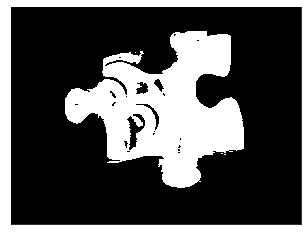

Prediction #6, accuracy:98.78%


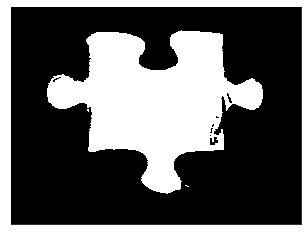

Prediction #7, accuracy:98.64%


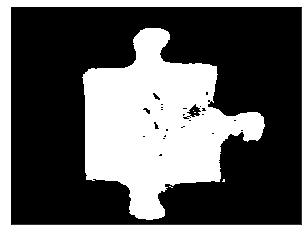

Prediction #8, accuracy:97.94%


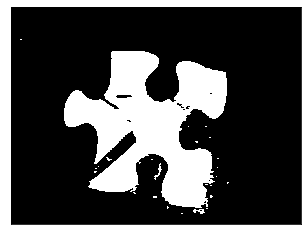

 17%|█████████████▎                                                                  | 1/6 [26:45<2:13:47, 1605.48s/it]

Average accuracy:96.88%
Fold: 1

Training bg_gmm:

Iteration #1, change in parameters 49.21211586110143
Iteration #2, change in parameters 0.013533835784904778
Iteration #3, change in parameters 0.0494544532744908
Iteration #4, change in parameters 0.11331528953107946
Iteration #5, change in parameters 0.1476951014332219
Iteration #6, change in parameters 0.14007777153593243
Iteration #7, change in parameters 0.10201363750061596
Iteration #8, change in parameters 0.0857178886769897
Iteration #9, change in parameters 0.09872281501473411
Iteration #10, change in parameters 0.0961829920332297
Iteration #11, change in parameters 0.0687559637786748
Iteration #12, change in parameters 0.038405249196826904
Iteration #13, change in parameters 0.027674757437788605
Iteration #14, change in parameters 0.0327132722362148
Iteration #15, change in parameters 0.036802598479569834
Iteration #16, change in parameters 0.03939547986511804
Iteration #17, change in parameters 0.04112271303480507
Iteration 

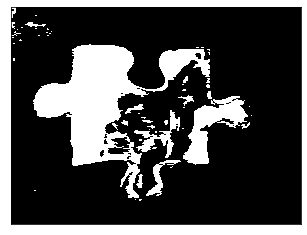

Prediction #2, accuracy:97.68%


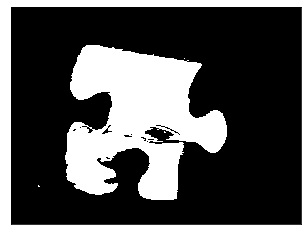

Prediction #3, accuracy:96.95%


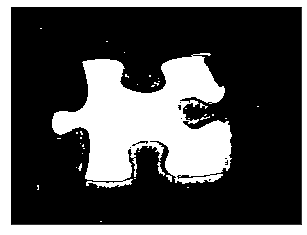

Prediction #4, accuracy:98.79%


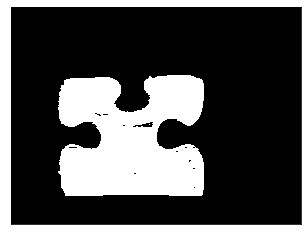

Prediction #5, accuracy:98.76%


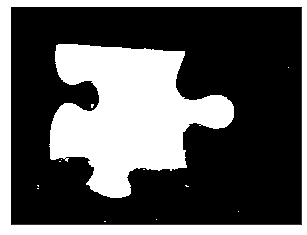

Prediction #6, accuracy:97.5%


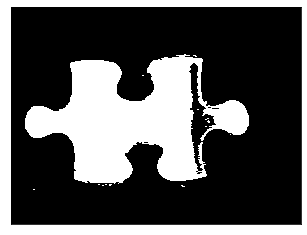

Prediction #7, accuracy:97.59%


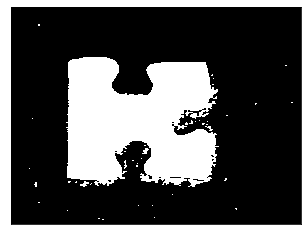

Prediction #8, accuracy:95.8%


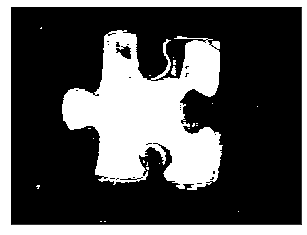

 33%|██████████████████████████▋                                                     | 2/6 [52:07<1:45:22, 1580.54s/it]

Average accuracy:96.34%
Fold: 2

Training bg_gmm:

Iteration #1, change in parameters 48.67151968592083
Iteration #2, change in parameters 0.009871012672012604
Iteration #3, change in parameters 0.03210991590735214
Iteration #4, change in parameters 0.09925804912861193
Iteration #5, change in parameters 0.1667507796730459
Iteration #6, change in parameters 0.15770130346900216
Iteration #7, change in parameters 0.12119722876109412
Iteration #8, change in parameters 0.10207737129597705
Iteration #9, change in parameters 0.11105040429270342
Iteration #10, change in parameters 0.09555115052710154
Iteration #11, change in parameters 0.06720916859015028
Iteration #12, change in parameters 0.047560079984394696
Iteration #13, change in parameters 0.044984464552802236
Iteration #14, change in parameters 0.042091601286200514
Iteration #15, change in parameters 0.03881830481906152
Iteration #16, change in parameters 0.037577298951175134
Iteration #17, change in parameters 0.0417845771407723
Itera

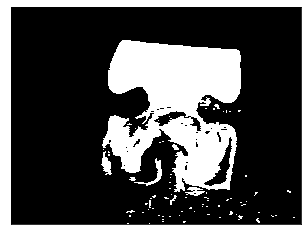

Prediction #2, accuracy:88.7%


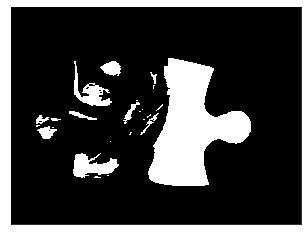

Prediction #3, accuracy:94.83%


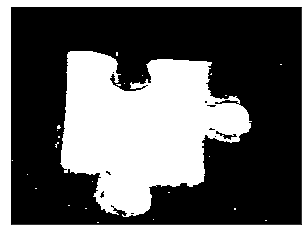

Prediction #4, accuracy:95.69%


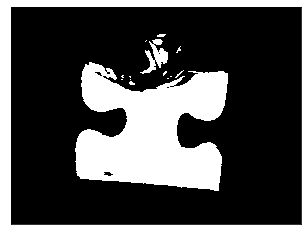

Prediction #5, accuracy:99.22%


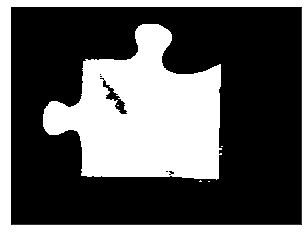

Prediction #6, accuracy:98.52%


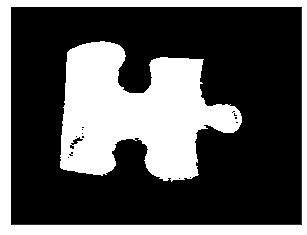

Prediction #7, accuracy:97.31%


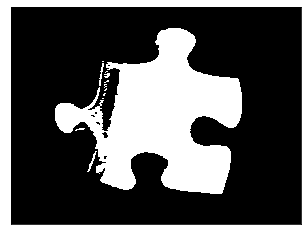

Prediction #8, accuracy:99.12%


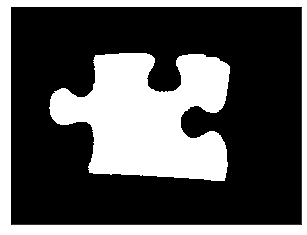

 50%|███████████████████████████████████████                                       | 3/6 [1:16:47<1:17:30, 1550.29s/it]

Average accuracy:95.97%
Fold: 3

Training bg_gmm:

Iteration #1, change in parameters 48.362621952513464
Iteration #2, change in parameters 0.003114823627288445
Iteration #3, change in parameters 0.011982656243098272
Iteration #4, change in parameters 0.05053076361746674
Iteration #5, change in parameters 0.11661770711023138
Iteration #6, change in parameters 0.157390762974084
Iteration #7, change in parameters 0.14597656948376148
Iteration #8, change in parameters 0.10050298813194777
Iteration #9, change in parameters 0.08449647963412285
Iteration #10, change in parameters 0.07885222032877016
Iteration #11, change in parameters 0.07534686824165701
Iteration #12, change in parameters 0.06700650492528812
Iteration #13, change in parameters 0.05619938948821126
Iteration #14, change in parameters 0.04464835558161569
Iteration #15, change in parameters 0.03339804827569115
Iteration #16, change in parameters 0.02374369074049104
Iteration #17, change in parameters 0.01706611958674857
Iterati

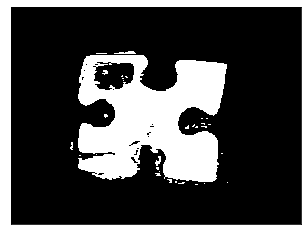

Prediction #2, accuracy:87.28%


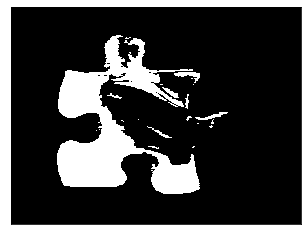

Prediction #3, accuracy:99.19%


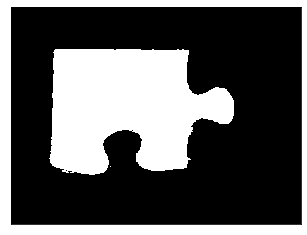

Prediction #4, accuracy:98.64%


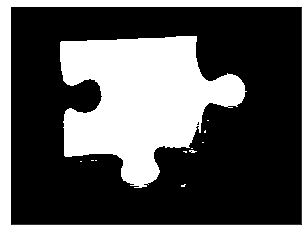

Prediction #5, accuracy:98.31%


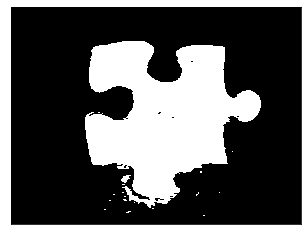

Prediction #6, accuracy:98.06%


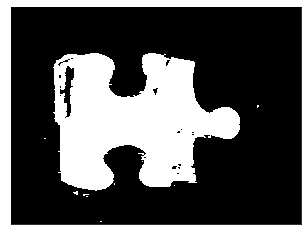

Prediction #7, accuracy:84.46%


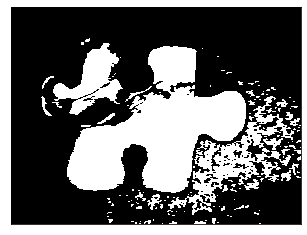

Prediction #8, accuracy:93.93%


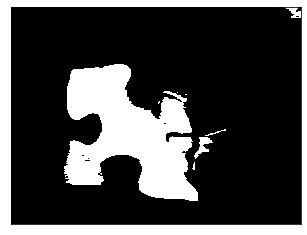

 67%|█████████████████████████████████████████████████████▎                          | 4/6 [1:39:46<49:57, 1498.83s/it]

Average accuracy:94.55%
Fold: 4

Training bg_gmm:

Iteration #1, change in parameters 48.29818918360368
Iteration #2, change in parameters 0.005688935895066758
Iteration #3, change in parameters 0.022491094189082676
Iteration #4, change in parameters 0.0806234925000478
Iteration #5, change in parameters 0.14376062962825895
Iteration #6, change in parameters 0.16065834226801762
Iteration #7, change in parameters 0.14481332184171022
Iteration #8, change in parameters 0.12789268115948513
Iteration #9, change in parameters 0.11741043963669212
Iteration #10, change in parameters 0.10149914659988572
Iteration #11, change in parameters 0.07139693186737751
Iteration #12, change in parameters 0.04172714132580556
Iteration #13, change in parameters 0.036101012673261705
Iteration #14, change in parameters 0.030377234860849842
Iteration #15, change in parameters 0.02108163937161693
Iteration #16, change in parameters 0.014401798150027761
Iteration #17, change in parameters 0.014024354644567787
Ite

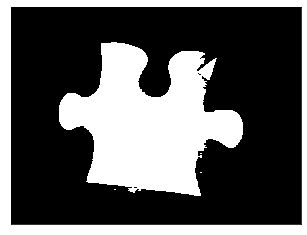

Prediction #2, accuracy:85.3%


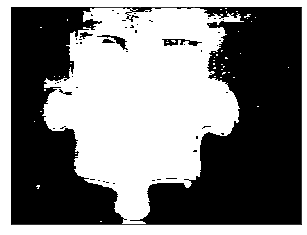

Prediction #3, accuracy:85.04%


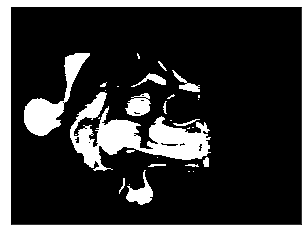

Prediction #4, accuracy:88.67%


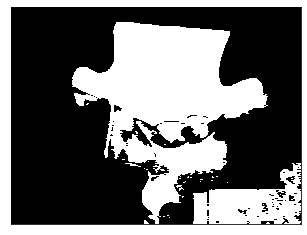

Prediction #5, accuracy:82.11%


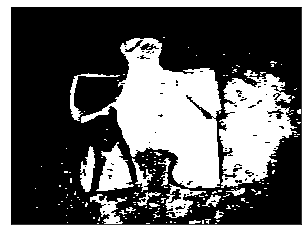

Prediction #6, accuracy:91.65%


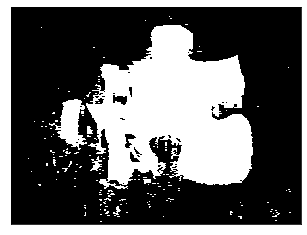

Prediction #7, accuracy:98.04%


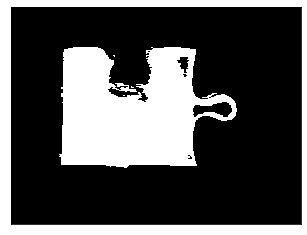

Prediction #8, accuracy:86.91%


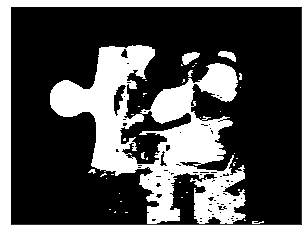

 83%|██████████████████████████████████████████████████████████████████▋             | 5/6 [2:08:05<25:58, 1558.79s/it]

Average accuracy:89.61%
Fold: 5

Training bg_gmm:

Iteration #1, change in parameters 48.89550318981494
Iteration #2, change in parameters 0.0020014797027247226
Iteration #3, change in parameters 0.0052420227023579945
Iteration #4, change in parameters 0.0178124807410677
Iteration #5, change in parameters 0.06152001951682863
Iteration #6, change in parameters 0.12265330952100836
Iteration #7, change in parameters 0.16576664975380193
Iteration #8, change in parameters 0.1684633522829388
Iteration #9, change in parameters 0.14302117334312897
Iteration #10, change in parameters 0.09979366036559524
Iteration #11, change in parameters 0.040132578071230315
Iteration #12, change in parameters 0.014825395744644887
Iteration #13, change in parameters 0.018795809262439726
Iteration #14, change in parameters 0.018067092160979892
Iteration #15, change in parameters 0.015785976755465198
Iteration #16, change in parameters 0.013559051131992083
Iteration #17, change in parameters 0.011760654825916261

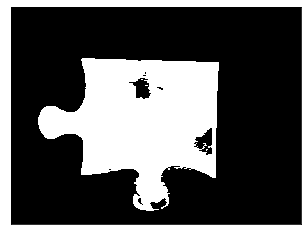

Prediction #2, accuracy:97.29%


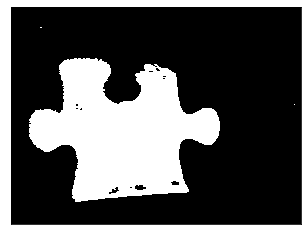

Prediction #3, accuracy:97.89%


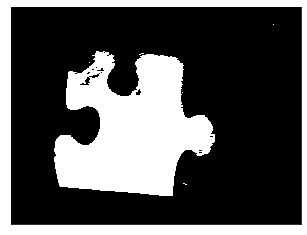

Prediction #4, accuracy:92.07%


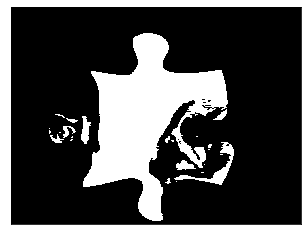

Prediction #5, accuracy:94.24%


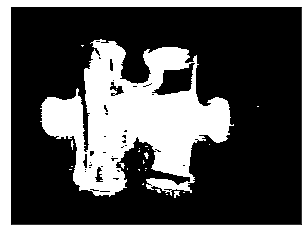

Prediction #6, accuracy:98.23%


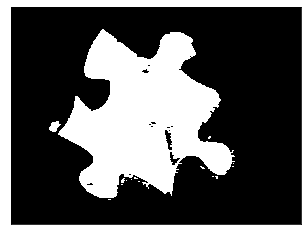

Prediction #7, accuracy:99.14%


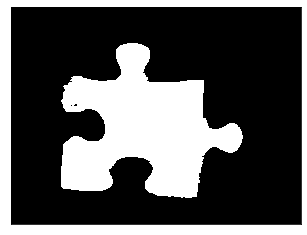

Prediction #8, accuracy:87.63%


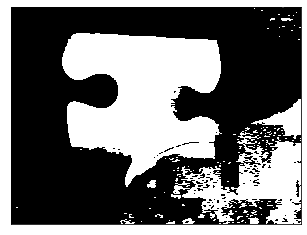

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:36:19<00:00, 1563.33s/it]

Average accuracy:95.63%

The accuracy scores achieved for each fold:
[96.88, 96.34, 95.97, 94.55, 89.61, 95.63]

The final accuracy of the system: 94.83


In [17]:
cross_val_manager(folds=6)